# TP1 - Arbres de décision, sélection de modèles
--------------------------------------------------------------------------

### Librairies et outils

In [1]:
import numpy as np
from collections import Counter
import pickle
import matplotlib.pyplot as plt
try:
    import pydot  #pour l'affichage graphique d'arbres
except ImportError:
    print("Pydot non disponible pour l'affichage graphique, allez sur http://www.webgraphviz.com/ pour generer un apercu de l'arbre")

In [2]:
###############################
# Fonctions auxiliaires
###############################

def p_log_p(freq):
    """ fonction pour calculer \sum p_i log(p_i) """
    return np.nan_to_num(np.sum(freq*np.log2(freq)))

def entropy(y):
    """ calcul de l'entropie d'un ensemble"""
    ylen = float(y.size)
    if ylen <= 1:
        return 0
    freq = np.array(list(Counter(y).values()))/ylen
    return -p_log_p(freq)

def entropy_cond(y_list):
    h, total = 0.,0.
    for y in y_list:
        h += len(y)*entropy(y)
        total += len(y)
    return h/total

###############################
# Classes
###############################


class Classifier(object):
    """ Classe generique d'un classifieur
        Dispose de 3 méthodes :
            fit pour apprendre
            predict pour predire
            score pour evaluer la precision
    """
    def fit(self,data,y):
        raise NotImplementedError("fit non  implemente")
    def predict(self,data):
        raise NotImplementedError("predict non implemente")
    def score(self,data,y):
        return (self.predict(data)==y).mean()


class Split(object):
    """ Permet de coder un split pour une variable continue
    """
    def __init__(self,idvar=None,threshold=None,gain=None):
        """
        :param idvar: numero de la variable de split
        :param threshold: seuil
        :param gain: gain d'information du split
        :return:
        """
        self.idvar=idvar
        self.threshold=threshold
        self.gain=gain

    def predict(self,data):
        """ Prediction pour une matrice d'exemples, -1 si <= threshold, +1 sinon
        :param x: matrice d'exemples
        :return: vecteur des labels
        """
        if len(data.shape)==1:
            data=data.reshape((1,data.shape[0]))
        return [-1 if data[i,self.idvar]<=self.threshold else 1 for i in range(data.shape[0])]

    @staticmethod
    def best_gain(x,y):
        """  calcul le meilleur seuil pour la colonne x (1-dimension) et les labels y
        :param x: vecteur 1d des donnees
        ;param y: vecteur des labels
        :return:
        """
        ylen = float(y.size)
        idx_sorted = np.argsort(x)
        h=entropy(y)
        xlast=x[idx_sorted[0]]
        split_val=x[idx_sorted[0]]
        hmin = h
        for i in range(y.size):
            if x[idx_sorted[i]]!=xlast:
                htmp = entropy_cond([y[idx_sorted[:i]], y[idx_sorted[i:]]])
                if htmp<hmin:
                    hmin=htmp
                    split_val=(xlast+x[idx_sorted[i]])/2.
            xlast=x[idx_sorted[i]]
        return (h-hmin/ylen),split_val

    @staticmethod
    def find_best_split(data,y):
        if len(data.shape)==1:
            data = data.reshape((1,data.shape[0]))
        hlist = [[Split.best_gain(data[:,i],y),i] for i in range(data.shape[1])]
        (h,threshold),idx= max(hlist)
        return Split(idx,threshold,h)

    def __str__(self):
        return "var %s, thresh %f (gain %f)" %(self.idvar,self.threshold, self.gain)

class Node(Classifier):
    """ Noeud d'un arbre
    """
    def __init__(self,split=None,parent=None,left=None,right=None,leaf=True,depth=-1,label=None,**kwargs):
        """
        :param split:  split du noeud
        :param parent: noeud parent, None si root
        :param left: fils gauche
        :param right: fils droit
        :param leaf: boolean vrai si feuille
        :param depth: profondeur
        :param label: label preponderant
        :return:
        """
        self.split, self.parent, self.left, self.right, self.leaf, self.label, self.depth = \
                                            split, parent, left, right, leaf, label, depth
        self.info = dict(kwargs)

    def predict(self,data):
        if len(data.shape)==1:
            data=data.reshape((1,data.shape[0]))
        if self.leaf:
            return [self.label]*data.shape[0]
        return [self.left.predict(data[i,:])[0] if res<0 else self.right.predict(data[i,:])[0]
                for i, res in enumerate(self.split.predict(data))]

    def fit(self, data, y):
        counts=Counter(y)
        self.split=Split.find_best_split(data, y)
        self.label = counts.most_common()[0][0]

    def __str__(self):
        if self.leaf:
            return "Leaf : %s" % (self.label,)
        return "Node : %s (%s)" % (self.split,self.info)

class DecisionTree(Classifier):
    """ Arbre de decision
    """

    def __init__(self,max_depth=None,min_samples_split=2):
        """
        :param max_depth: profondeur max
        :param min_samples_split:  nombre d'exemples minimal pour pouvoir spliter le noeud
        :return:
        """
        self.max_depth, self.min_samples_split = max_depth, min_samples_split
        self.root = None

    def fit(self,data,y):
        """ apprentissage de l'arbre de maniere iterative
        on apprend un noeud, puis on cree les deux enfants de ce noeud, que l'on ajoute a la pile des noeuds
        a traiter par la suite (nodes_to_treat), ainsi que les index des exemples associes (dic_idx)
        """
        self.root = Node(depth=0)
        nodes_to_treat = [self.root]
        dic_idx = dict({self.root : range(len(y))})
        while len(nodes_to_treat)>0:
            # recuperation du noeud courant
            curnode = nodes_to_treat.pop()
            #recuperation de la liste des indices des exemples associes, x[idx_train,:] contient l'ensemble des
            #exemples a traiter
            idx_train = dic_idx.pop(curnode)
            # infos complementaires sur le nombre d'exemples en apprentissage par label
            for lab,clab in Counter(y[idx_train]).items():
                curnode.info[lab]=clab
            curnode.fit(data[idx_train,:],y[idx_train])

            # recupere les predictions pour partager entre fils droit et gauche les exemples
            pred = curnode.split.predict(data[idx_train,:])
            l_idx = [ idx_train[i] for i in range(len(idx_train)) if pred[i]<0 ]
            r_idx = list(set(idx_train).difference(l_idx))

            #Condition d'arrets
            if entropy(y[idx_train])==0 or curnode.depth >= self.max_depth or \
                    len(l_idx) < self.min_samples_split or len(r_idx) < self.min_samples_split:
                curnode.leaf=True
                continue
            #Creation des deux enfants
            curnode.left = Node(parent=curnode,depth=curnode.depth+1)
            curnode.right = Node(parent=curnode,depth=curnode.depth+1)
            curnode.leaf = False
            #On enregistre les indices correspondant aux deux noeuds
            dic_idx[curnode.left]=l_idx
            dic_idx[curnode.right]=r_idx
            #On ajoute les deux enfants a la liste des noeuds a traiter
            nodes_to_treat = [curnode.left,curnode.right]+nodes_to_treat

    def predict(self,data):
        return self.root.predict(data)

    def __str__(self):
        return self.print_tree()

    def to_dot(self,dic_var=None):
        s="digraph Tree {"
        cpt=0
        nodes = [(self.root,cpt)]
        while len(nodes)>0:
            curnode,idx = nodes.pop()
            labinfo = ",".join(["%s: %s" % (lab,slab) for lab,slab in curnode.info.items()])
            if not curnode.leaf:
                s+="%d [label=\"%s <= %f\n IG=%f\n " %(idx,curnode.split.idvar \
                    if not dic_var else dic_var[curnode.split.idvar],curnode.split.threshold,curnode.split.gain)
                s+= " %s \n \",shape=\"box\" ];\n"  % (labinfo,)
                lidx = cpt +1
                ridx = cpt +2
                s+= "%d -> %d; %d -> %d;\n" % (idx,lidx,idx,ridx)
                cpt+=2
                nodes += [(curnode.left,lidx),(curnode.right,ridx)]
            else:
                s+= "%d [label=\"label=%s\n %s \"];\n" %(idx,curnode.label,labinfo)
        return s+"}"

    def to_pdf(self,filename,dic_var=None):
        pydot.graph_from_dot_data(self.to_dot(dic_var))[0].write_pdf(filename)

    def print_tree(self,fields=None):
        s=""
        nodes=[self.root]
        while len(nodes)>0:
            curnode=nodes.pop()
            if type(curnode)==str:
                s+=curnode
            else:
                if not curnode.leaf:
                    s+= "\t"*curnode.depth + "var %s :  > %f \n"  %(str(curnode.split.idvar) if not fields else fields[curnode.split.idvar],curnode.split.threshold)
                    nodes+=[curnode.left, "\t"*curnode.depth + "var %s :  <= %f \n"  %(str(curnode.split.idvar) if not fields else fields[curnode.split.idvar],curnode.split.threshold), curnode.right]
                else:
                    s+= "\t"*curnode.depth + "class : %s %s\n" %(curnode.label,str(curnode.info))
        return s


[PS] - Les fonctions entropie(vect) et entropie_cond(list_vect) ont déjà été fournies.

## Entropie
----

Extraction des données

In [3]:
FILE="data/imdb_extrait.pkl"

# data : tableau (films,features), id2titles : dictionnaire id -> titre, 
# fields : id feature -> nom 
[data, id2titles, fields]=pickle.load(open(FILE,"rb")) 
# la derniere colonne est le vote 
datax=data[:,:32] 
datay=np.array([1 if x[33]>6.5 else -1 for x in data])

In [4]:
# Les 28 premiers attributs sont binaires
print(fields)

{0: 'Sci-Fi', 1: 'Crime', 2: 'Romance', 3: 'Animation', 4: 'Music', 5: 'Comedy', 6: 'War', 7: 'Horror', 8: 'Film-Noir', 9: 'Adult', 10: 'News', 11: 'Reality-TV', 12: 'Thriller', 13: 'Western', 14: 'Mystery', 15: 'Short', 16: 'Talk-Show', 17: 'Drama', 18: 'Action', 19: 'Documentary', 20: 'Musical', 21: 'History', 22: 'Family', 23: 'Adventure', 24: 'Fantasy', 25: 'Game-Show', 26: 'Sport', 27: 'Biography', 28: 'Duree', 29: 'couleur', 30: 'annee', 31: 'budget', 32: 'nb_votes', 33: 'rating'}


Entropie et entropie conditionnelle

In [5]:
# Seuls les 28 premiers attributs sont binaires (genre)

entropie = entropy(datay)

# Etant donné qu'il s'agit de la première partition
# On prend en compte l'ensemble de tous les labels
entropies_cond = np.zeros(28)

for attr in range(28):
    liste = []
    # On evite un np.unique sachant que les attributs sont binaires
    l1 = datay[np.where(datax[:, attr] == 0)]
    l2 = datay[np.where(datax[:, attr] == 1)]
    entropies_cond[attr] = entropy_cond([l1,l2])

entropie, entropies_cond

(0.98690894690212883,
 array([ 0.98094647,  0.98623973,  0.98690613,  0.98467258,  0.98689223,
         0.97090779,  0.97780903,  0.96421532,  0.98333215,  0.98690895,
         0.98690895,  0.98690895,  0.97545709,  0.98487557,  0.98678246,
         0.98637377,  0.98690895,  0.92624691,  0.9704709 ,  0.98565317,
         0.98444894,  0.97327102,  0.98502739,  0.98663702,  0.98462641,
         0.98690895,  0.98690733,  0.96582419]))

In [6]:
# Calcul de la différence
diff = np.abs(entropie - entropies_cond)
print(diff)
np.argmax(diff)

[  5.96247597e-03   6.69213184e-04   2.82066573e-06   2.23636433e-03
   1.67156922e-05   1.60011607e-02   9.09991844e-03   2.26936266e-02
   3.57679967e-03   1.11022302e-16   1.11022302e-16   1.11022302e-16
   1.14518586e-02   2.03337726e-03   1.26482227e-04   5.35179901e-04
   1.11022302e-16   6.06620351e-02   1.64380421e-02   1.25578097e-03
   2.46000763e-03   1.36379262e-02   1.88155339e-03   2.71923482e-04
   2.28254128e-03   1.11022302e-16   1.61241572e-06   2.10847547e-02]


17

#### [Q] - A quoi correspond une valeur de 0? Une valeur de 1? Quel est le meilleur attribut pour la première partition?


Soient X la variable aléatoire associée à un attribut et Y la variable aléatoire associée aux labels.

Une valeur de 0 signifie que H(Y) = H(Y|X) et donc que Y est indépendante de X (probabilité conditionnelle). Autrement, une valeur de 1 signifie que les deux variables sont dépendantes. Y serait donc déterminée par X.

On cherche à maximiser l'équiprobabilité (plus grande valeur pour H(Y)) et maximiser l'homogénéité (minimiser H(Y|X)). Par conséquent, choisir l'attribut pour lequel la différence est la plus grande.
Pour notre premier partitionnemment, on choisit l'attribut 17.

## Quelques expériences préliminaires
-----

In [7]:
from decisiontree import DecisionTree

dt = DecisionTree() 
dt.max_depth = 5
#on fixe la taille de l’arbre a 5 dt.min_samples_split = 2 
#nombre minimum d’exemples pour spliter un noeud 
dt.fit(datax,datay) 
dt.predict(datax[:100,:]) # nombre d'exemple a prendre en compte pour predire 
print(dt.score(datax,datay)) 
# dessine l’arbre dans un fichier pdf si pydot est installe. 
# dt.to_pdf("/tmp/test_tree.pdf",fields) 
# sinon utiliser http://www.webgraphviz.com/ 
# print(dt.to_dot(fields))
#ou dans la console 
print(dt.print_tree(fields))

0.736429038587
var Drama :  > 0.500000 
	var budget :  > 15660000.000000 
		var Duree :  > 115.500000 
			var budget :  > 36500000.000000 
				var Duree :  > 137.500000 
					class : 1 {1: 101, -1: 20}
				var Duree :  <= 137.500000 
					class : 1 {-1: 94, 1: 109}
			var budget :  <= 36500000.000000 
				var Sci-Fi :  > 0.500000 
					class : -1 {-1: 5, 1: 4}
				var Sci-Fi :  <= 0.500000 
					class : 1 {1: 252, -1: 31}
		var Duree :  <= 115.500000 
			var Biography :  > 0.500000 
				var annee :  > 2011.500000 
					class : -1 {-1: 2}
				var annee :  <= 2011.500000 
					class : 1 {1: 24, -1: 2}
			var Biography :  <= 0.500000 
				var Thriller :  > 0.500000 
					class : -1 {-1: 162, 1: 66}
				var Thriller :  <= 0.500000 
					class : -1 {1: 135, -1: 149}
	var budget :  <= 15660000.000000 
		var annee :  > 1973.500000 
			var Duree :  > 104.500000 
				var budget :  > 11158052.500000 
					class : 1 {1: 131, -1: 39}
				var budget :  <= 11158052.500000 
					class : 1 {-1: 25, 1:

In [8]:
# TEST avec d'autres profondeurs

dt.max_depth = 15
dt.fit(datax,datay) 
#dt.predict(datax[:100,:])
print(dt.score(datax,datay)) 
print(dt.print_tree(fields))

0.882057989972
var Drama :  > 0.500000 
	var budget :  > 15660000.000000 
		var Duree :  > 115.500000 
			var budget :  > 36500000.000000 
				var Duree :  > 137.500000 
					var Western :  > 0.500000 
						class : -1 {-1: 2}
					var Western :  <= 0.500000 
						var budget :  > 112500000.000000 
							var budget :  > 127500000.000000 
								var budget :  > 160000000.000000 
									class : 1 {1: 5}
								var budget :  <= 160000000.000000 
									var budget :  > 135000000.000000 
										var Duree :  > 175.000000 
											class : -1 {-1: 2}
										var Duree :  <= 175.000000 
											class : 1 {1: 3, -1: 1}
									var budget :  <= 135000000.000000 
										class : 1 {1: 2}
							var budget :  <= 127500000.000000 
								class : -1 {-1: 3}
						var budget :  <= 112500000.000000 
							var Comedy :  > 0.500000 
								var annee :  > 2003.000000 
									class : -1 {-1: 3, 1: 1}
								var annee :  <= 2003.000000 
									class : 1 {1: 3}
							var Comedy 

#### [Q] - Sur la base de données imdb, apprendre quelques arbres de profondeurs différentes. Visualiser-les. Que remarquez-vous quant au nombre d’exemples séparés à chaque niveau en fonction de la profondeur ? Est-ce normal ?

Par exemple, avec une profondeur de 5, on voit un nombre d'exemples séparés élevé au niveau des feuilles. Plus la profondeur augmente, plus ce nombre diminue car à chaque partitionnement, on travaille sur un sous ensemble et la profondeur définit le nombre de partitionnement, ce qui est donc tout à fait normal.

#### [Q] - Calculer les scores de bonnes classification. Comment ils évoluent en fonction de la profondeur ? Est-ce normal ?

<table>
    <tr>
        <td>Profondeur</td>
        <td>5</td>
        <td>7</td>
        <td>10</td>
        <td>15</td>
        <td>30</td>
    </tr>
    <tr>
        <td>Score</td>
        <td>0.74</td>
        <td>0.77</td>
        <td>0.82</td>
        <td>0.88</td>
        <td>0.90</td>
    </tr>
</table>

On remarque que plus la profondeur augmente, plus le score de bonne classification augmente. Ce qui est tout à fait normal puisque la profondeur définit le nombre de partitionnements, on affine donc la classification. Néanmoins, une précision s'impose, notre prédiction a été faite sur la base d'apprentissage.

#### [Q] - Ces scores sont-ils un indicateur fiable du comportement de l’algorithme ? Comment obtenir un indicateur plus fiable ?

Comme dit précédemment, ces scores ne sont pas fiables puisque l'algorithme prédit sur sa base d'apprentissage d'où les scores paraissent satisfaisants. De plus, on voit ici que plus la profondeur de l'arbre augmente, plus l'algorithme s'approche du surapprentissage.

Il faudrait séparer notre base de données en deux : une base d'apprentissage qui sert à construire l'arbre et une base de test sur laquelle on prédit.

## Sur et sous apprentissage
----

Tracer les courbes de l’erreur en apprentissage et 
de l’erreur en test en fonction de la profondeur du modèle.

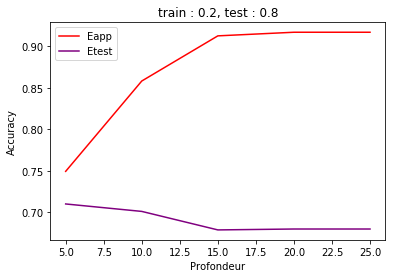

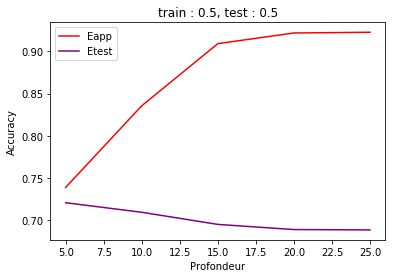

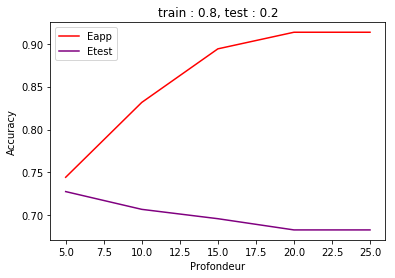

In [10]:
# On génère une liste d'indices mélangés
ind = np.arange(len(datax))
np.random.shuffle(ind)

cp = [0.2,0.5,0.800]
coupures = int(len(datax)*cp[0]), int(len(datax)*cp[1]), int(len(datax)*cp[2])
# On effectue la coupure au niveau des indices
inds_app = [ind[:c] for c in coupures]
inds_test = [ind[c:] for c in coupures]

dt = DecisionTree() # Intialisation de l'arbre
for i in range(3):
    score_app, score_test = [], []
    for prof in range(5,30,5):
        
        dt.max_depth = prof
        dt.fit(datax[inds_app[i]],datay[inds_app[i]])
        score_app.append(dt.score(datax[inds_app[i]],datay[inds_app[i]]))
        score_test.append(dt.score(datax[inds_test[i]],datay[inds_test[i]]))
    
    # Affichage 
    plt.title("train : " + str(cp[i]) + ", test : " + str(round(1-cp[i],1)))
    plt.plot(range(5,30,5), score_app, c="red", label="Eapp")
    plt.plot(range(5,30,5), score_test, c="purple", label="Etest")
    plt.xlabel("Profondeur")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

[R] - On remarque que dans tous les cas, plus la profondeur est élevée, plus les performances en apprentissage sont meilleures (même comportement dans chacun des graphes). Tandis que la courbe des performances sur l'ensemble de test est décroissante.

Quand il y a peu d'exemples d'apprentissage, la courbe de performances sur l'ensemble de test décroit rapidement tandis qu'avec beaucoup d'exemples d'apprentissage, il décroit un peu plus lentement et montre des performances légèrement meilleures.

#### [Q] - Vos résultats vous semblent-ils fiables et stables ? Comment les améliorer ?

Les résultats ne semblent pas fiables et après plusieurs exécutions, on remarque plusieurs variations au niveau de la courbe des performances sur l'ensemble de test. On choisit aléatoirement les exemples pour construire notre ensemble d'apprentissage. Une partie de notre base d'exemples n'est donc pas utilisée pour l'apprentissage or le choix des exemples peut avoir un impact sur l'apprentissage (ex: points extrêmes). 

Il faudrait utiliser tous les exemples de la base pour l'apprentissage
-> *Validation croisée*

## Validation croisée : sélection de modèle
------

In [11]:
import copy

def crossValidation(datax,datay,k,depth):
    """ datax: base d'exemples
        datay: labels
        k: nombres d'ensembles d'apprentissage (split)
        depth: profondeur
        retourne le score de performances obtenu après sélection par
        validation croisée.
    """
    
    x = np.arange(len(datax))
    np.random.shuffle(x)
    
    E = list(np.array_split(x,k)) # Split en k ensembles
    L = [] # liste de scores
    dt = DecisionTree() # Initialisation de l'arbre
    
    for i in range(k):
        Eapp = copy.deepcopy(E)
        
        del Eapp[i] # On retire l'ensemble qui va nous servir de test
        dt.max_depth=depth
        # Apprentissage sur les n-1 ensembles
        ind = np.concatenate(Eapp)
        dt.fit(datax[ind],datay[ind])
        # Prédiction sur l'ensemble de test
        L.append(dt.score(datax[E[i]],datay[E[i]]))
        
    return np.array(L).mean() # Erreur moyenne


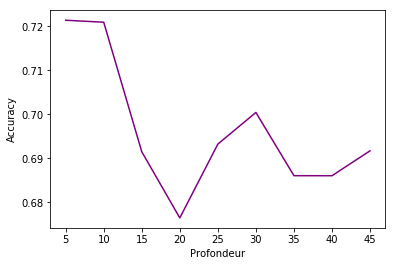

In [14]:
scores = [crossValidation(datax, datay, 10, prof) for prof in range(5,50,5)]
    
# Affichage 
plt.plot(range(5,50,5), scores, c="purple")
plt.xlabel("Profondeur")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
    

C:\Users\Steban\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


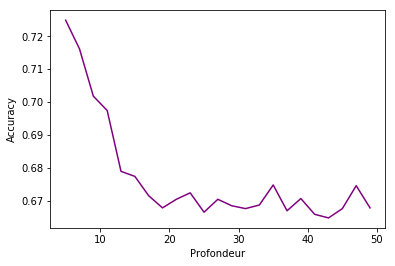

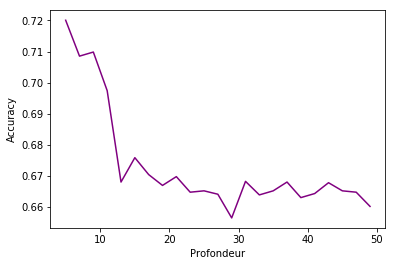

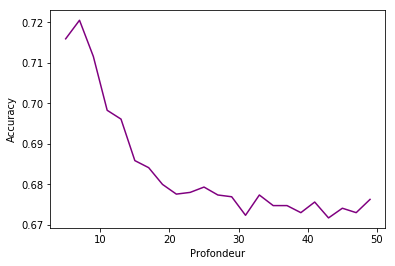

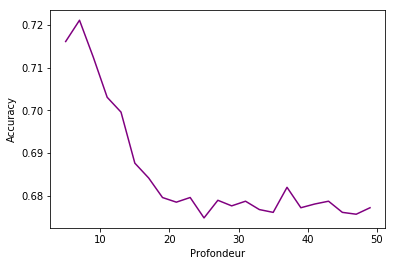

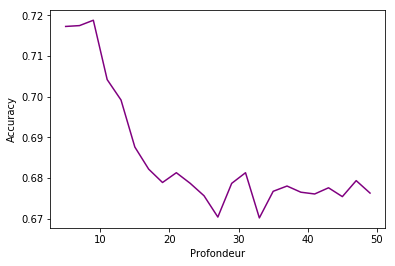

In [15]:
from sklearn import tree, cross_validation

ks = [2,3,7,10,15]

for k in ks:
    scores = []
    for prof in range(5, 50, 2):
        clf = tree.DecisionTreeClassifier(max_depth=prof)
        clf.fit(datax, datay)
        s = cross_validation.cross_val_score(estimator=clf, X=datax, y=datay, cv=k)
        scores.append(np.mean(s))
    
    # Affichage 
    plt.plot(range(5,50,2), scores, c="purple")
    plt.xlabel("Profondeur")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()